# Email Spam Detection - Exploratory Data Analysis (EDA)

This notebook performs comprehensive EDA on the email spam dataset to understand:
- Dataset structure and statistics
- Distribution of spam vs ham emails
- Text characteristics and patterns
- Data quality and preprocessing needs

**Project:** Email Spam Detection System  
**Purpose:** Engineering Degree Project  
**Date:** December 2025

## 1. Import Required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import re
import string
from collections import Counter

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Dataset

**Dataset Options:**
1. **Kaggle SMS Spam Collection** - Most commonly used
2. **Enron Email Dataset** - For advanced projects
3. **SpamAssassin Public Corpus**

For this project, we'll use the SMS Spam Collection dataset which is perfect for email spam detection.

**Download from:** https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

Place the dataset CSV file in this directory (`ml_model/`) as `spam.csv`

In [2]:
# Load the dataset
# Note: Update the file path based on your dataset location
try:
    df = pd.read_csv('spam.csv', encoding='latin-1')
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ Dataset not found. Please download 'spam.csv' from Kaggle.")
    print("URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset")
    # Create sample data for demonstration
    df = pd.DataFrame({
        'v1': ['ham', 'spam', 'ham', 'spam', 'ham'],
        'v2': [
            'Hello, how are you?',
            'WINNER! You have won $1000. Click here now!',
            'Meeting at 3pm tomorrow',
            'FREE entry to win cash prizes! Text WIN to 12345',
            'Can you call me when you are free?'
        ]
    })
    print("Using sample data for demonstration.")

✅ Dataset loaded successfully!


## 3. Data Overview and Cleaning

In [3]:
# Display first few rows
print("📊 First 5 rows of the dataset:")
print(df.head())

📊 First 5 rows of the dataset:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [4]:
# Dataset shape
print(f"\n📏 Dataset Shape: {df.shape}")
print(f"   Total emails: {df.shape[0]}")
print(f"   Features: {df.shape[1]}")


📏 Dataset Shape: (5572, 5)
   Total emails: 5572
   Features: 5


In [5]:
# Column information
print("\n📋 Column Information:")
print(df.info())


📋 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [6]:
# Clean the dataset - keep only relevant columns
# The spam.csv typically has columns: v1 (label), v2 (message), and some unnamed columns
if 'v1' in df.columns and 'v2' in df.columns:
    df = df[['v1', 'v2']]
    df.columns = ['label', 'message']
elif 'Category' in df.columns and 'Message' in df.columns:
    df = df[['Category', 'Message']]
    df.columns = ['label', 'message']
else:
    # Use first two columns
    df = df.iloc[:, :2]
    df.columns = ['label', 'message']

print("✅ Dataset cleaned and renamed:")
print(df.head())

✅ Dataset cleaned and renamed:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [7]:
# Check for missing values
print("\n🔍 Missing Values:")
print(df.isnull().sum())

# Remove duplicates
original_size = len(df)
df = df.drop_duplicates()
print(f"\n🗑️ Duplicates removed: {original_size - len(df)}")
print(f"   New dataset size: {len(df)}")


🔍 Missing Values:
label      0
message    0
dtype: int64

🗑️ Duplicates removed: 403
   New dataset size: 5169


## 4. Label Distribution Analysis

In [8]:
# Count of spam vs ham
print("📊 Label Distribution:")
print(df['label'].value_counts())
print(f"\nPercentages:")
print(df['label'].value_counts(normalize=True) * 100)

📊 Label Distribution:
label
ham     4516
spam     653
Name: count, dtype: int64

Percentages:
label
ham     87.366996
spam    12.633004
Name: proportion, dtype: float64


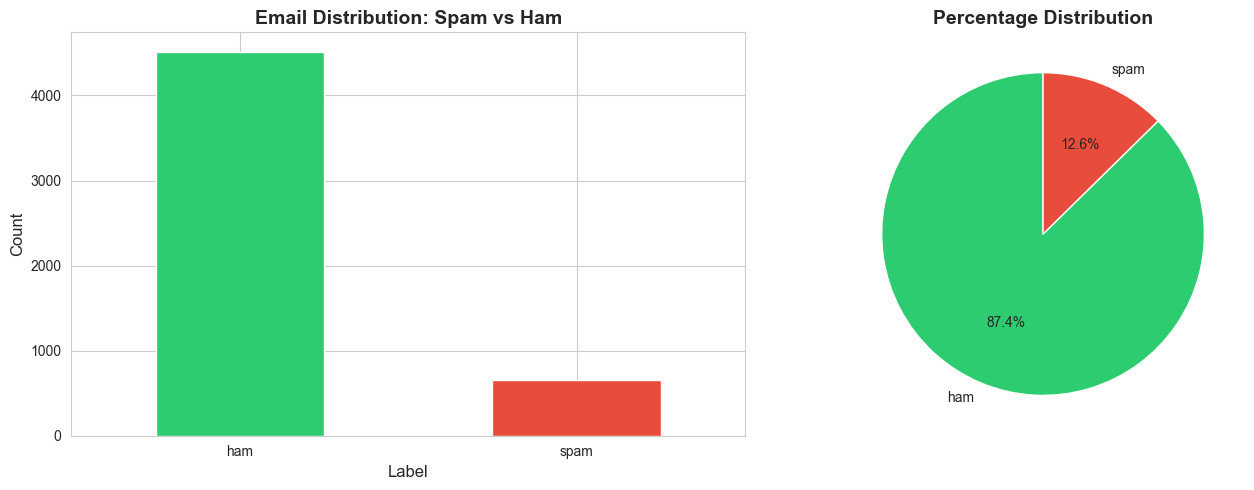

In [9]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Email Distribution: Spam vs Ham', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Pie chart
df['label'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Percentage Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 5. Text Length Analysis

In [10]:
# Add text length features
df['length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))

print("📏 Text Statistics:")
print(df.groupby('label')[['length', 'word_count']].describe())

📏 Text Statistics:
       length                                                           \
        count        mean        std   min    25%    50%    75%    max   
label                                                                    
ham    4516.0   70.459256  56.358207   2.0   34.0   52.0   90.0  910.0   
spam    653.0  137.891271  30.137753  13.0  132.0  149.0  157.0  224.0   

      word_count                                                      
           count       mean        std  min   25%   50%   75%    max  
label                                                                 
ham       4516.0  14.134632  11.116240  1.0   7.0  11.0  18.0  171.0  
spam       653.0  23.681470   5.967672  2.0  22.0  25.0  28.0   35.0  


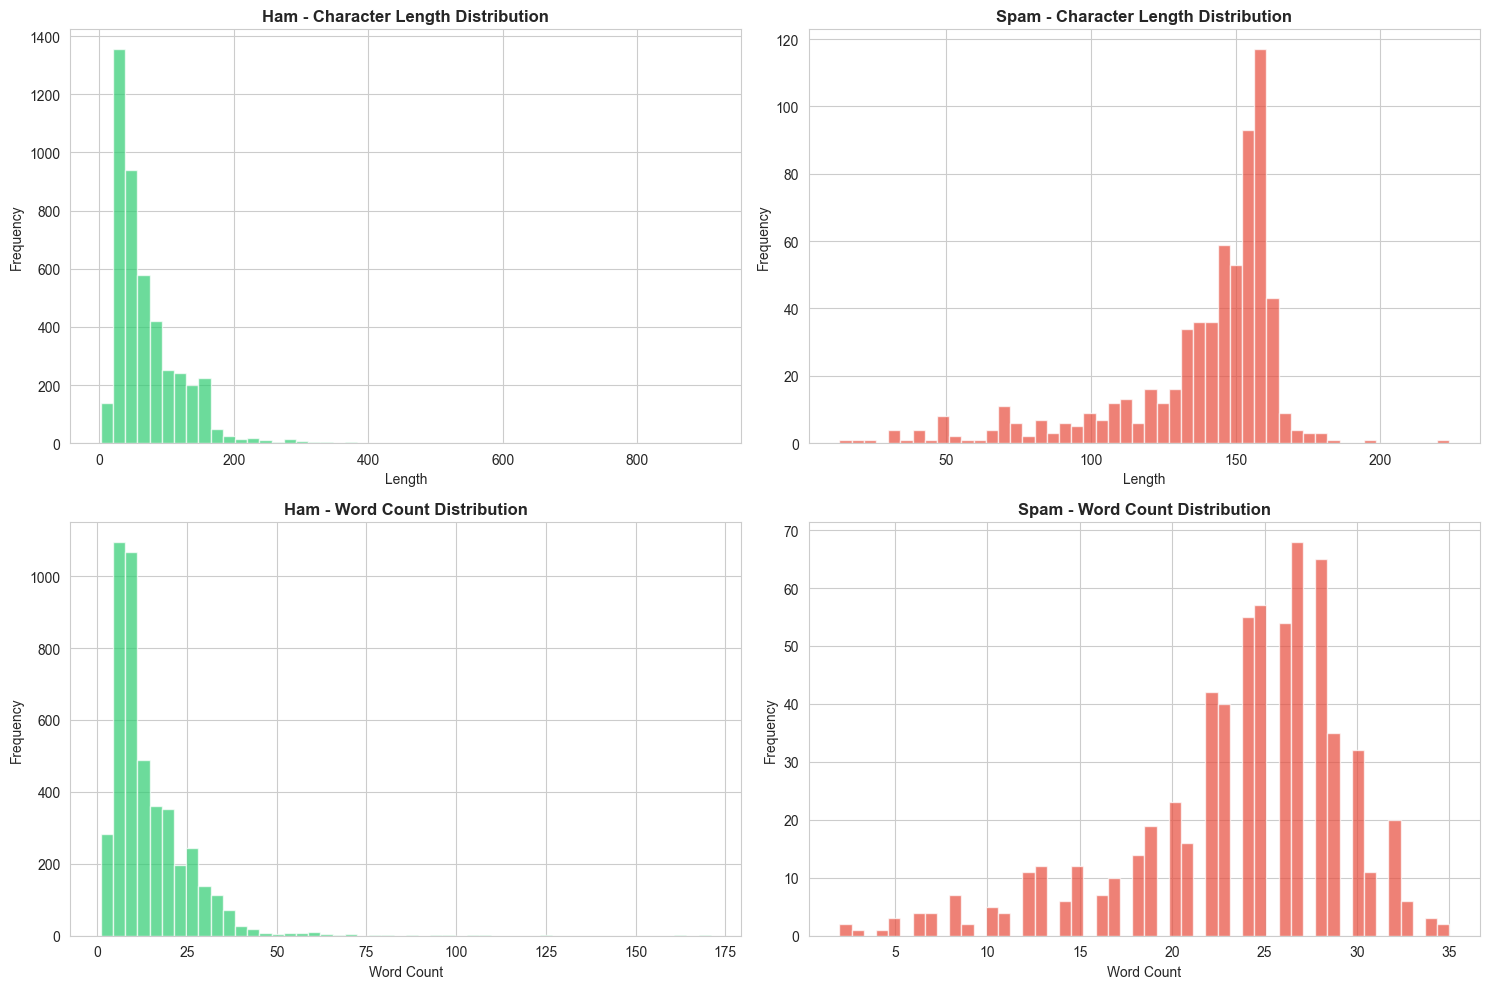

In [11]:
# Visualize text length distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution
df[df['label'] == 'ham']['length'].hist(bins=50, ax=axes[0, 0], color='#2ecc71', alpha=0.7)
axes[0, 0].set_title('Ham - Character Length Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Frequency')

df[df['label'] == 'spam']['length'].hist(bins=50, ax=axes[0, 1], color='#e74c3c', alpha=0.7)
axes[0, 1].set_title('Spam - Character Length Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Length')
axes[0, 1].set_ylabel('Frequency')

# Word count distribution
df[df['label'] == 'ham']['word_count'].hist(bins=50, ax=axes[1, 0], color='#2ecc71', alpha=0.7)
axes[1, 0].set_title('Ham - Word Count Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')

df[df['label'] == 'spam']['word_count'].hist(bins=50, ax=axes[1, 1], color='#e74c3c', alpha=0.7)
axes[1, 1].set_title('Spam - Word Count Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 6. Word Cloud Visualization

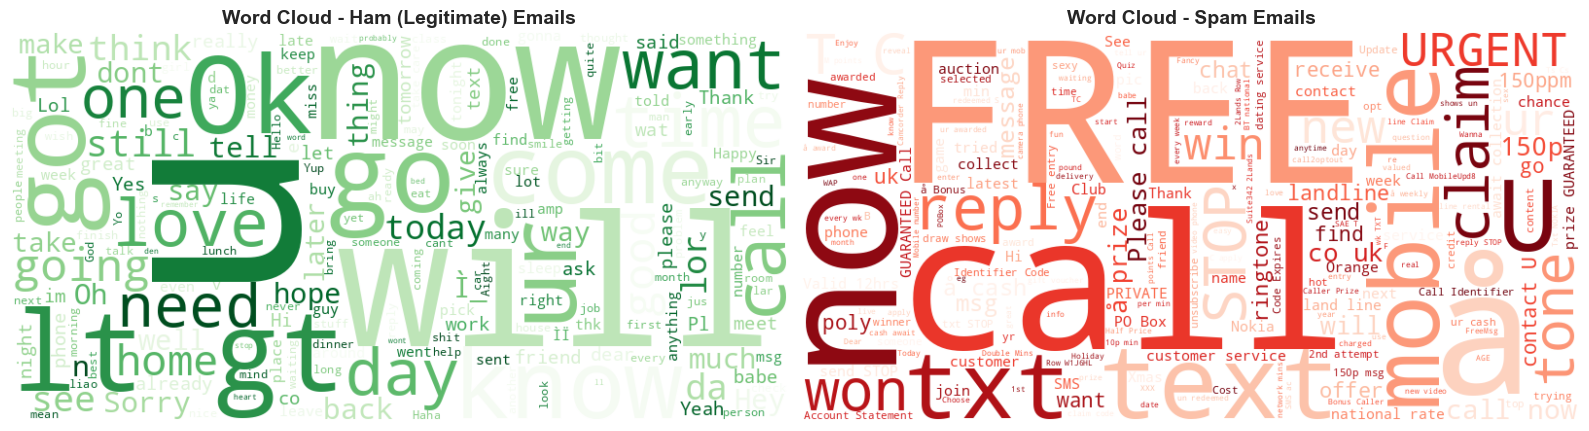

In [12]:
# Create word clouds for spam and ham
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ham word cloud
ham_text = ' '.join(df[df['label'] == 'ham']['message'].values)
wordcloud_ham = WordCloud(width=800, height=400, background_color='white', 
                          colormap='Greens').generate(ham_text)
axes[0].imshow(wordcloud_ham, interpolation='bilinear')
axes[0].set_title('Word Cloud - Ham (Legitimate) Emails', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Spam word cloud
spam_text = ' '.join(df[df['label'] == 'spam']['message'].values)
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', 
                           colormap='Reds').generate(spam_text)
axes[1].imshow(wordcloud_spam, interpolation='bilinear')
axes[1].set_title('Word Cloud - Spam Emails', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 7. Most Common Words Analysis

In [13]:
# Function to get top words
def get_top_words(text, n=20):
    words = []
    for message in text:
        words.extend(str(message).lower().split())
    
    # Remove common stopwords manually
    common_words = ['the', 'a', 'to', 'of', 'and', 'in', 'is', 'you', 'that', 'it', 
                   'for', 'on', 'with', 'as', 'your', 'this', 'be', 'are', 'have']
    words = [w for w in words if w not in common_words and len(w) > 2]
    
    return Counter(words).most_common(n)

# Get top words for ham and spam
ham_top_words = get_top_words(df[df['label'] == 'ham']['message'])
spam_top_words = get_top_words(df[df['label'] == 'spam']['message'])

print("📝 Top 20 Words in HAM emails:")
for word, count in ham_top_words:
    print(f"   {word}: {count}")

print("\n📝 Top 20 Words in SPAM emails:")
for word, count in spam_top_words:
    print(f"   {word}: {count}")

📝 Top 20 Words in HAM emails:
   but: 395
   i'm: 358
   not: 355
   can: 338
   will: 305
   get: 285
   just: 273
   &lt;#&gt;: 254
   when: 250
   how: 243
   what: 227
   got: 221
   all: 215
   like: 212
   was: 200
   come: 199
   know: 197
   then: 190
   its: 188
   good: 171

📝 Top 20 Words in SPAM emails:
   call: 298
   free: 157
   from: 118
   txt: 114
   text: 96
   mobile: 95
   reply: 93
   claim: 89
   stop: 83
   now: 79
   our: 77
   get: 68
   just: 66
   new: 64
   send: 55
   only: 55
   prize: 53
   won: 53
   nokia: 53
   now!: 53


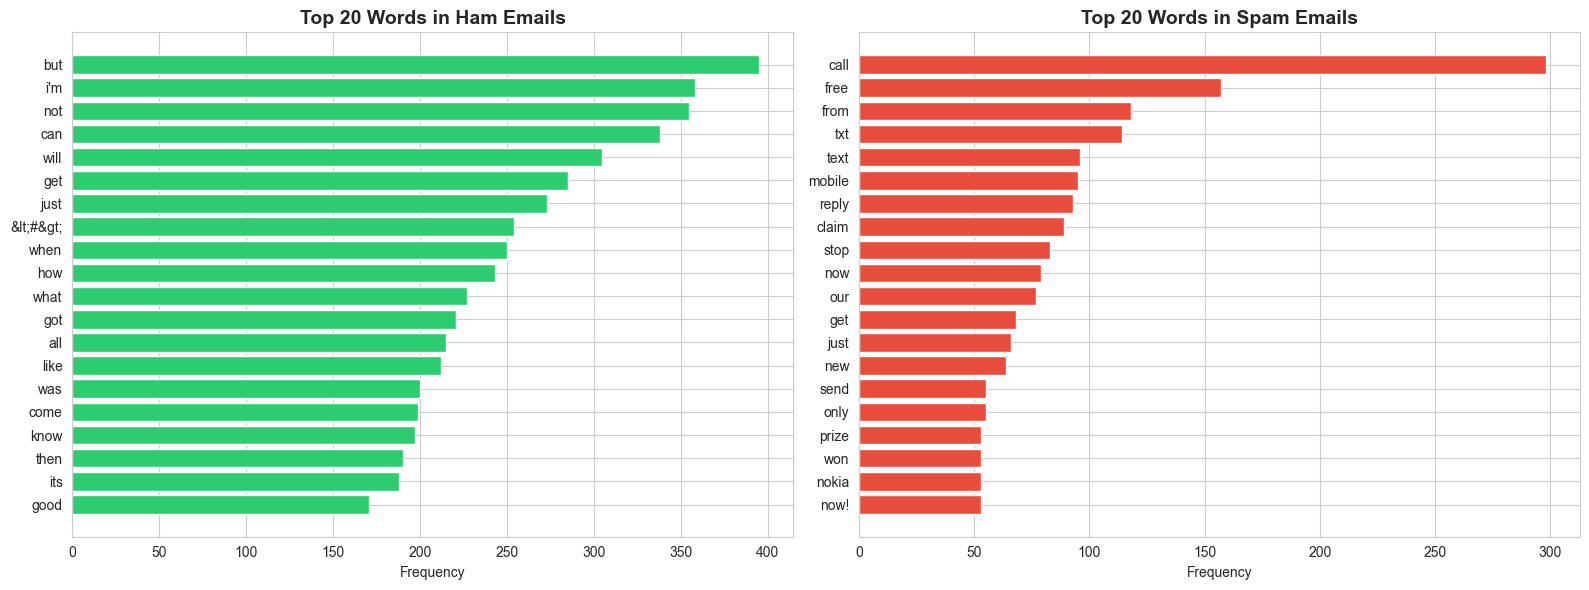

In [14]:
# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ham top words
ham_words = [word for word, count in ham_top_words]
ham_counts = [count for word, count in ham_top_words]
axes[0].barh(ham_words, ham_counts, color='#2ecc71')
axes[0].set_title('Top 20 Words in Ham Emails', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Spam top words
spam_words = [word for word, count in spam_top_words]
spam_counts = [count for word, count in spam_top_words]
axes[1].barh(spam_words, spam_counts, color='#e74c3c')
axes[1].set_title('Top 20 Words in Spam Emails', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 8. Key Insights and Summary

### 📊 Data Insights:
1. **Dataset Balance**: Check if dataset is balanced or imbalanced
2. **Text Length**: Spam messages tend to be longer/shorter than ham
3. **Common Patterns**: Spam contains more promotional words (free, win, prize, urgent)
4. **Next Steps**: Text preprocessing and model training

### 🎯 Important Observations for Model:
- Spam often contains: promotional language, urgency, money-related terms
- Ham contains: normal conversational language, personal communications
- TF-IDF vectorization will be ideal for this task
- Recommended models: Naive Bayes, Logistic Regression

### 📁 Save Cleaned Dataset

In [15]:
# Save cleaned dataset for model training
df_clean = df[['label', 'message']]
df_clean.to_csv('spam_cleaned.csv', index=False)
print("✅ Cleaned dataset saved as 'spam_cleaned.csv'")
print(f"\nFinal dataset shape: {df_clean.shape}")
print(f"Ready for model training!")

✅ Cleaned dataset saved as 'spam_cleaned.csv'

Final dataset shape: (5169, 2)
Ready for model training!
